In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [201]:
def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

def sigmoid(x, a, b, c, d):
    return a / (1 + np.exp(-b*(x-c)) + d)

In [202]:
countries = ['Germany', 'France', 'Australia', 'Brazil', 'Italy', 'Spain',
       'Canada', 'Netherlands', 'Switzerland', 'India', 'Sweden',
       'South Africa', 'Mexico', 'Japan', 'Belgium', 'Russia', 'Poland',
       'Portugal', 'Finland', 'Czech Republic', 'Denmark', 'New Zealand',
       'Austria', 'Argentina', 'Norway', 'Indonesia', 'Chile', 'Colombia',
       'Israel', 'Costa Rica', 'Peru']

In [203]:
# get the citation data

paper_df_list = []
biodiversity_research_df_list = []

for country in countries:
    biodiversity_research_df = pd.read_csv(f'Final_project_data/{country}_biodiversity_research.csv')
    biodiversity_research_df_list.append(biodiversity_research_df)
    citations = np.array(biodiversity_research_df['Times Cited, All Databases'], dtype='int')
    pub_years = np.array(biodiversity_research_df['Publication Year'], dtype='int')
    paper_ages = 2022 - pub_years
    paper_df = pd.DataFrame(dict({'Paper Age': paper_ages, 'Citations': citations}))
    paper_df = paper_df[paper_df['Paper Age'] <= 25]
    paper_df = paper_df.reset_index(drop=True)
    paper_df_list.append(paper_df)

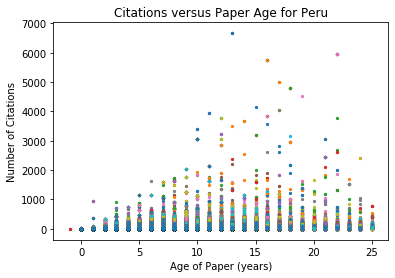

In [204]:
# plot the age of each paper and its citation counts

for country, paper_df in zip(countries, paper_df_list):

    plt.scatter(paper_df['Paper Age'], paper_df['Citations'], s=5)
    plt.xlabel('Age of Paper (years)')
    plt.ylabel('Number of Citations')
    plt.title(f'Citations versus Paper Age for {country}')

In [205]:
popt_list = []
for country, paper_df in zip(countries, paper_df_list):
    popt, pcov = curve_fit(sigmoid, paper_df['Paper Age'], paper_df['Citations'], bounds=(0, np.inf), maxfev=5000)
    popt_list.append(popt)

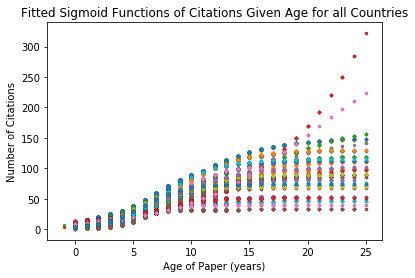

In [206]:
for country, popt, paper_df in zip(countries, popt_list, paper_df_list):
    plt.scatter(paper_df['Paper Age'], sigmoid(paper_df['Paper Age'], *popt), label=country, s=5)
    #plt.legend()
    plt.xlabel('Age of Paper (years)')
    plt.ylabel('Number of Citations')
    plt.title(f'Fitted Sigmoid Functions of Citations Given Age for all Countries')
    
plt.show()

In [207]:
# normalize the paper citations by this factor
for popt, biodiversity_research_df in zip(popt_list, biodiversity_research_df_list):
        biodiversity_research_df['Adjusted Citations'] = biodiversity_research_df['Times Cited, All Databases'] / sigmoid(2022 - biodiversity_research_df['Publication Year'], *popt)

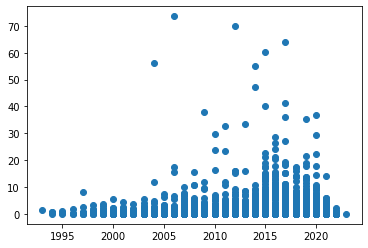

In [208]:
plt.scatter(biodiversity_research_df_list[3]['Publication Year'], biodiversity_research_df_list[3]['Adjusted Citations'])

In [209]:
# export function info for each country to .csv file
popt_arr = np.asarray(popt_list)

adjusted_citations_df = pd.DataFrame()
adjusted_citations_df['Country'] = countries
adjusted_citations_df['a'] = popt_arr[:,0]
adjusted_citations_df['b'] = popt_arr[:,1]
adjusted_citations_df['c'] = popt_arr[:,2]
adjusted_citations_df['d'] = popt_arr[:,3]
adjusted_citations_df.to_csv('adjusted_citations_sigmoid_params.csv')

In [210]:
def flatten_strip(list):
    # remove extra space around each element in the input list
    return [i.strip() for i in list]

In [211]:
def a_big_one(raw_data,column_name):
    row_before_dropna = raw_data.shape[0] 
    
    cleaned_data = raw_data.dropna(axis=0, subset=[column_name])# delete the row with nan in this column
    row_after_dropna = cleaned_data.shape[0] 
    cleaned_data = cleaned_data.reset_index()
    
    org_nation = {}
    temp_dicts_key_author=[]
    
    for i in range(len(raw_data)):
        string = cleaned_data.loc[i, column_name]

        state = -1

        temp_authors = ''
        temp_adds = ''

        temp_name = []
        temp_country = ''

        temp_dict_key_author={}
        temp_dict_key_org={}

        for s in string:
            if s == '[':
                state = 0
            elif s == ']':
                state = 1
            elif state == 1 and s == ';':
                state = 2

            if state == 0:
                temp_authors+=s
            elif state == 1:
                temp_adds+=s
            elif state == 2 and temp_authors:

                auth = flatten_strip(temp_authors[1:].split(';'))

                add = flatten_strip(temp_adds[2:].split(','))

                org = add[0]


                nation = add[-1].split(' ')[-1]

                temp_authors,temp_adds='',''
                if org not in org_nation.keys():
                    org_nation[org] = nation

                for author in auth:
                    if author in temp_dict_key_author.keys():
                        if (org,org_nation[org]) not in temp_dict_key_author[author]:
                            temp_dict_key_author[author].append((org,org_nation[org]))
                    else:
                        temp_dict_key_author[author] = [(org,org_nation[org])]

        temp_dicts_key_author.append(temp_dict_key_author)
        
    author_num_for_each_country_by_paper =[]
    for paper in temp_dicts_key_author:
        author_num_for_each_country_by_paper.append({})
        for author in paper.keys():
            adds = paper[author]
            for add in adds:
                if add[-1] not in author_num_for_each_country_by_paper[-1].keys():
                    author_num_for_each_country_by_paper[-1][add[-1]] = 1
                else:
                    author_num_for_each_country_by_paper[-1][add[-1]]+=1
                    
                    
    dif_org_for_each_country_by_paper =[]
    for paper in temp_dicts_key_author:
        dif_org_for_each_country_by_paper.append({})
        for author in paper.keys():
            adds = paper[author]
            for add in adds:
                if add not in dif_org_for_each_country_by_paper[-1].keys():
                    dif_org_for_each_country_by_paper[-1][add] = 1
                else:
                    dif_org_for_each_country_by_paper[-1][add]+=1

    return author_num_for_each_country_by_paper,dif_org_for_each_country_by_paper,org_nation

In [212]:
def get_org_counts(dif_org_for_each_country_by_paper, country_str):
    org_counts = []
    for index, paper_dict in enumerate(dif_org_for_each_country_by_paper):
        org_count = 0
        for key in dif_org_for_each_country_by_paper[index].keys():
            if country_str in key:
                org_count += 1
        org_counts.append(org_count)
    return org_counts

def get_author_counts(author_num_for_each_country_by_paper, country_str):
    author_counts = []
    for index, paper_dict in enumerate(author_num_for_each_country_by_paper):
        author_count = 0
        for key in author_num_for_each_country_by_paper[index].keys():
            if country_str in key:
                author_count += author_num_for_each_country_by_paper[index][key]
        author_counts.append(author_count)
    return author_counts

In [216]:
# read in each country dataframe and perform feature engineering
protected_df = pd.read_csv('Final_project_data/protected_land_cleaned.csv')
param_df = pd.read_csv('adjusted_citations_sigmoid_params.csv')
param_df = param_df.drop(['Unnamed: 0', 'Country'], axis=1)
param_array = param_df.to_numpy()

for popt,country_str in zip(param_array, countries):
    country_research_df = pd.read_csv(f"Final_project_data/{country_str}_biodiversity_research.csv")
    # paper age and adjusted citations
    country_research_df_new = pd.DataFrame()
    country_research_df['Paper Age'] = 2022 - country_research_df['Publication Year']
    country_research_df_new['Publication Year'] = country_research_df['Publication Year']
    country_research_df_new['Paper Age'] = country_research_df['Paper Age']
    country_research_df_new['Adjusted Citations'] = country_research_df['Times Cited, All Databases'] / sigmoid(country_research_df['Paper Age'], *popt)
    author_num_for_each_country_by_paper,dif_org_for_each_country_by_paper,org_nation = a_big_one(country_research_df, 'Addresses')
    
    mod_string = country_str
    if country_str == 'United States':
        mod_string = 'USA'
    elif country_str == "China (People's Republic of)":
        mod_string = 'China'
        
    author_counts = get_author_counts(author_num_for_each_country_by_paper, mod_string)
    org_counts = get_org_counts(dif_org_for_each_country_by_paper, mod_string)
    
    # number of authors from given country per paper
    country_research_df_new['Country Specific Authors'] = author_counts
    
    # number of organizations in a given country per paper
    country_research_df_new['Country Specific Orgs'] = org_counts
    
    # write new research df to file
    country_research_df_new.to_csv(f"{country_str}_biodiversity_research_sigmoid.csv")

[8.90375502e+01 3.54017660e-01 7.09212115e+00 6.77822806e-04]
[1.00843242e+02 3.09800273e-01 8.34789928e+00 1.16229946e-02]
[143.91694118   0.28747402   9.37055413   0.19566949]
[1.01681352e+02 2.55175979e-01 1.10663159e+01 1.58945730e-02]
[5.34114436e+01 5.09816413e-01 5.10891134e+00 1.77988578e-02]
[8.63800156e+01 3.36435509e-01 7.67217559e+00 8.02568890e-03]
[1.12960848e+02 3.37376701e-01 8.05415410e+00 1.38753757e-03]
[1.29574626e+02 3.23555989e-01 7.75563353e+00 8.72962756e-04]
[1.49129529e+02 2.80598179e-01 9.05344815e+00 6.16755103e-04]
[4.71171080e+01 4.54146335e-01 6.20283488e+00 2.65499151e-02]
[1.50770544e+02 2.75642992e-01 8.93663733e+00 1.46077968e-03]
[128.39185959   0.29578002  10.09376217   0.14278242]
[1.72142034e+02 2.18208856e-01 1.44322173e+01 7.97538731e-04]
[5.12156493e+01 4.43991196e-01 5.79187247e+00 3.88541422e-03]
[8.25400730e+01 3.20327453e-01 7.10497283e+00 6.23020839e-03]
[34.66707545  0.72690395  4.42028026  0.06658569]
[4.05744542e+01 5.78792237e-01 4.893